In [1]:
import numpy as np
import scipy
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.rcParams['pdf.fonttype'] = 42

import torch
import torchvision
from torch import nn, optim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.io import loadmat
import os, sys
import torchvision.transforms as transforms
import string
from  collections import defaultdict
from sklearn.linear_model import LassoCV

# images = loadmat('baoimg.mat').get('img')
%run clean_cornets.py

In [2]:
from torchvision import datasets, transforms

data_dir = 'stimuli/wordsets_1000cat_8ex/'
transform = {'train': transforms.Compose([transforms.Resize((224,224)),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),}

chosen_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform =  transform[x]) for x in ['train']}
dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size = 80,shuffle = False) for x in ['train']}

wordlist = chosen_datasets['train'].classes


In [3]:
dataiter = iter(dataloaders['train'])

nBli = {}; nBli['it'] = []; nBli['h'] = []; nBli['out'] = []
net = CORNet_Z_nonbiased_words()
checkpoint = torch.load('models/save_lit_no_bias_z_79_full_nomir.pth.tar')['state_dict']
for key in list(checkpoint.keys()):
    if 'module.' in key:
        checkpoint[key.replace('module.', '')] = checkpoint[key]
        del checkpoint[key]
net.load_state_dict(checkpoint)
# net.eval() 
    
for i in range(100):
    stimtemp, classes = next(dataiter)
    # nBli['v1'], nBli['v2'], nBli['v4'], nBli['it'], nBli['h'],  nBli['out'] = net(stimtemp.float())
    _,_,_,varIt,varh, varOut = net(stimtemp.float())
    nBli['it'].extend(varIt.detach().numpy())
    nBli['h'].extend(varh.detach().numpy())
    nBli['out'].extend(varOut.detach().numpy())
    print(i)


###  Biased literate network
# Bli = {}; Bli['it'] = []; Bli['h'] = []; Bli['out'] = []
# net = CORNet_Z_biased_words()
# checkpoint = torch.load('models/save_lit_bias_z_79_full_nomir.pth.tar')['state_dict']
# for key in list(checkpoint.keys()):
#     if 'module.' in key:
#         checkpoint[key.replace('module.', '')] = checkpoint[key]
#         del checkpoint[key]
# net.load_state_dict(checkpoint)
    
# for i in range(100):
#     stimtemp, classes = next(dataiter)
#     _,_,_,varIt,varh, varOut = net(stimtemp.float())
#     Bli['it'].extend(varIt.detach().numpy())
#     Bli['h'].extend(varh.detach().numpy())
#     Bli['out'].extend(varOut.detach().numpy())
#     print(i)

## Loading all the three network and extracting representation from all the hidden units
# ili = {}; ili['it'] = []; ili['h'] = []; ili['out'] = []
# net = CORnet_Z_tweak()
# checkpoint = torch.load('models/save_illit_z_79_full_nomir.pth.tar')['state_dict']
# # checkpoint = torch.load('models/save_pre_z_49_full_nomir.pth.tar')['state_dict']

# for key in list(checkpoint.keys()):
#     if 'module.' in key:
#         checkpoint[key.replace('module.', '')] = checkpoint[key]
#         del checkpoint[key]
# net.load_state_dict(checkpoint)

# for i in range(100):
#     stimtemp, classes = next(dataiter)
#     _,_,_,varIt,varh, varOut = net(stimtemp.float())
#     ili['it'].extend(varIt.detach().numpy())
#     ili['h'].extend(varh.detach().numpy())
#     ili['out'].extend(varOut.detach().numpy())
#     print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


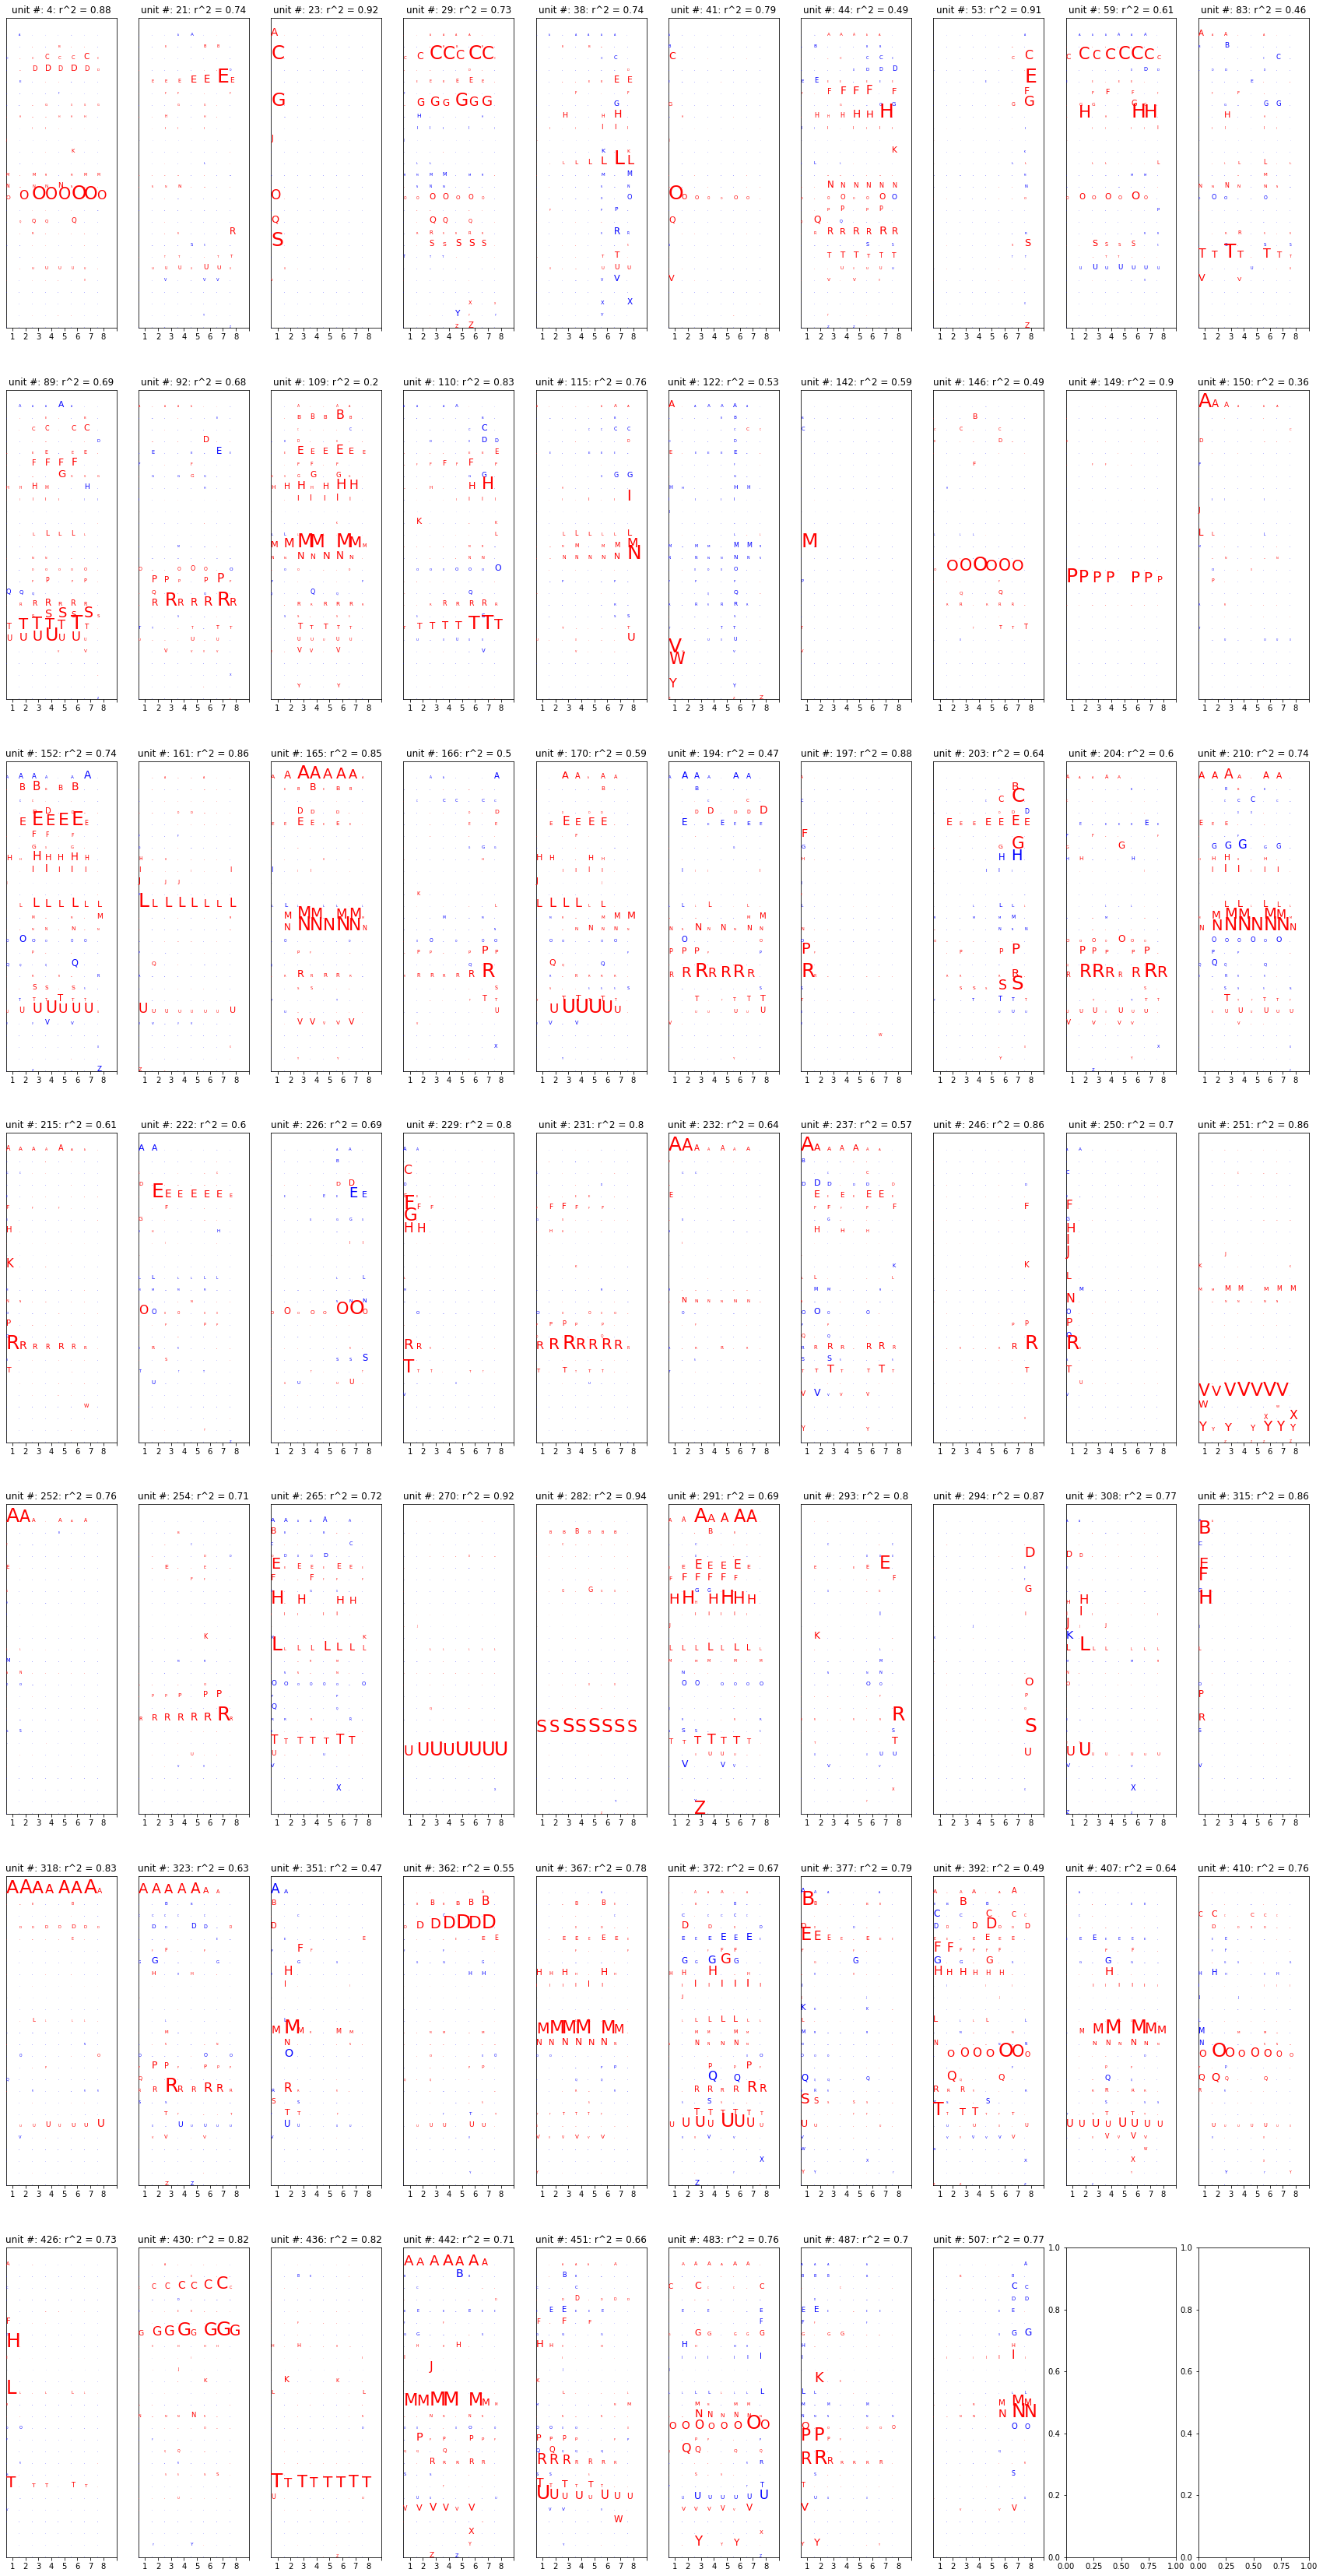

In [4]:
# Encoding model to predict the unit response

# Data 
stimword = np.transpose(np.tile(wordlist,(8, 1))).flatten()
x = nBli['h'] #stimulus 

# Units selective for words identified by Thomas
NBL = 1; # Non-biased literate network flag 
if NBL:
    wordSelUnit = [4,21,23,29,38,41,44,53,59,83,89,92,109,110,115,122,142,146,149,150,152,161,165,166,170, 
              194,197,203,204,210,215,222,226,229,231,232,237,246,250,251,252,254,265,270,282,291,293,294,
              308,315,318,323,351,362,367,372,377,392,407,410,426,430,436,442,451,483,487,507]
else:
    wordSelUnit = [53,122,165,294,464,465,466,470,471,472,474,476,478,480,481,482,483,484,485,486,487,489,490,
              491,493,494,498,499,501]
    

# Setting up the parameters to perform PC
out = np.take(x,wordSelUnit[:],1)  # Analysing properties of individual word selective units

# Initializing the variables
max_len = max(map(len, stimword)); 
fig, axs = plt.subplots(7,10, figsize=(30,60), facecolor='w', edgecolor='k')
axs = axs.ravel();
strlist = list(string.ascii_lowercase) # storing charaacters from A-Z


# Building the regression matrix
Xmat = np.zeros((len(stimword), 26*8)) 
modelcoef = np.zeros((len(wordSelUnit),np.shape(Xmat)[1]))

for i, seq in enumerate(stimword):
    mpt = round(len(seq)/2)
    for j, char in enumerate(seq[:mpt]):  # Left half of the words 
        if char in strlist:
            pid = (strlist.index(char)*8) + j
            Xmat[i,pid] += 1 
            
    for j, char in enumerate(seq[mpt:][::-1]):  # right half of the words 
        if char in strlist:
            pid = (strlist.index(char)*8) + 7 - j
            Xmat[i,pid] += 1 


rfit = np.zeros((len(wordSelUnit)))
for npc in range(len(wordSelUnit)): 
    yobs = out[:,npc]       
    reg = LassoCV(cv=5, random_state=0).fit(Xmat, yobs)   
    corrval,pval = scipy.stats.pearsonr(Xmat@reg.coef_, out[:,npc])
    rfit[npc] = corrval**2
    modelcoef[npc,:] = reg.coef_

    # Visualizing the coefficients
    charcoef = np.reshape(reg.coef_,[26,8])
    maxval = np.max(abs(charcoef)); charcoef = charcoef*25/maxval
    for r in range(np.size(charcoef,0)):
        strchar = string.ascii_uppercase[r]
        for c in range(np.size(charcoef,1)):
            strcol = 'red' if charcoef[r,c] >0 else 'blue'
            axs[npc].text( c,25-r, strchar, FontSize = abs(charcoef[r,c]), color = strcol)
            axs[npc].set_xticks(np.arange(0.5,9,1)); axs[npc].set_xticklabels(['1','2','3','4','5','6','7','8']);
            axs[npc].set_yticks(np.arange(0.5,27,1)); axs[npc].set_yticklabels([]);
            axs[npc].yaxis.set_ticks_position('none') 


    axs[npc].set_title('unit #: ' + str(wordSelUnit[npc])+ ': r^2 = '+str(round(rfit[npc],2)))


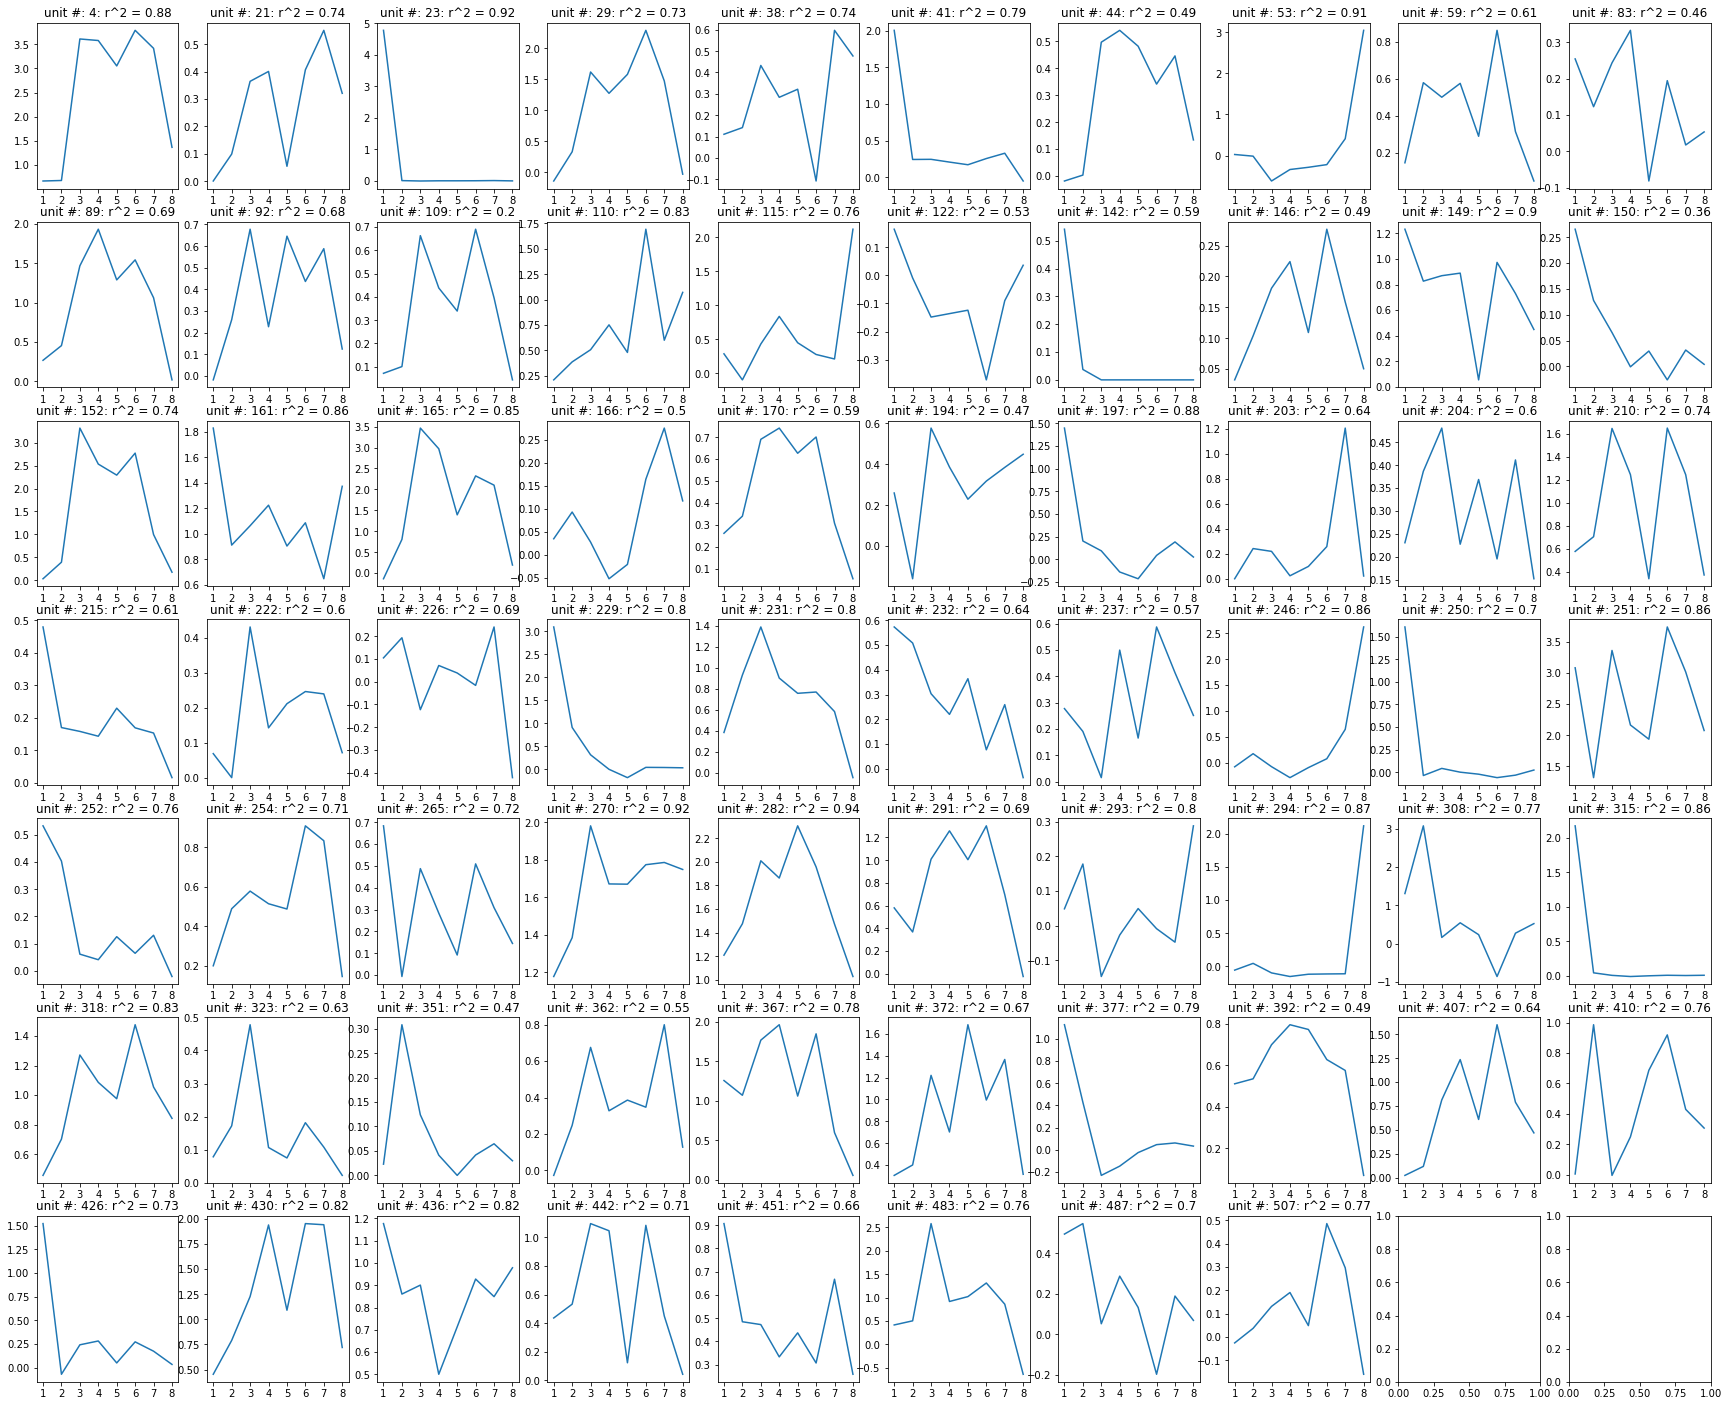

In [93]:
# Plotting position tuning of model parameters

# Building the regression matrix
Xmat = np.zeros((len(stimword), 26*8)) 
for i, seq in enumerate(stimword):
    mpt = round(len(seq)/2)
    for j, char in enumerate(seq[:mpt]):  # Left half of the words 
        if char in strlist:
            pid = (strlist.index(char)*8) + j
            Xmat[i,pid] += 1 
            
    for j, char in enumerate(seq[mpt:][::-1]):  # right half of the words 
        if char in strlist:
            pid = (strlist.index(char)*8) + 7 - j
            Xmat[i,pid] += 1 

            
modelcoef = np.zeros((len(wordSelUnit),np.shape(Xmat)[1]))
for npc in range(len(wordSelUnit)): 
    yobs = out[:,npc]       
    reg = LassoCV(cv=5, random_state=0).fit(Xmat, yobs)   
    corrval,pval = scipy.stats.pearsonr(Xmat@reg.coef_, out[:,npc])
    rfit[npc] = corrval**2
    modelcoef[npc,:] = reg.coef_
    

# fig, axs = plt.subplots(7,10, figsize=(30,25), facecolor='w', edgecolor='k')
# axs = axs.ravel();
# for npc in range(len(wordSelUnit)):
#     # Visualizing the coefficients
#     charcoef = np.mean(np.reshape(modelcoef[npc,:],[26,8]),0)
#     axs[npc].plot(charcoef)
#     axs[npc].set_xticks(np.arange(0,8,1)); axs[npc].set_xticklabels(['1','2','3','4','5','6','7','8']);

#     axs[npc].set_title('unit #: ' + str(wordSelUnit[npc])+ ': r^2 = '+str(round(rfit[npc],2)))


In [225]:
peakloc = np.zeros((len(wordSelUnit)))
npeaks = np.zeros((len(wordSelUnit)))
meancoef = np.zeros((len(wordSelUnit)))
for npc in range(len(wordSelUnit)):
    charcoef = np.mean(np.reshape(modelcoef[npc,:],[26,8]),0)
    peakloc[npc] = np.argmax(charcoef)
    meancoef[npc] = np.mean(abs(charcoef)/np.max(charcoef))  # Mean normalized area
    idx = list(set(range(8)) - set([np.max([0,peakloc[npc]-1]), peakloc[npc], np.min([7, peakloc[npc]+1])]))
    npeaks[npc] = len(np.where(charcoef[idx] > np.max(charcoef)*.64)[0])


sel_id = np.array(list(set(np.where(npeaks < 1)[0]) - set([15,46])))
oth_id = np.array(list(set(range(len(wordSelUnit))) - set(sel_id)))


array([2., 0., 1., 5., 0., 7., 5., 7., 0., 0., 6., 0., 6., 0., 2., 0., 2.,
       0., 7., 0., 0., 5., 7., 1., 0., 2., 1., 0., 0.])

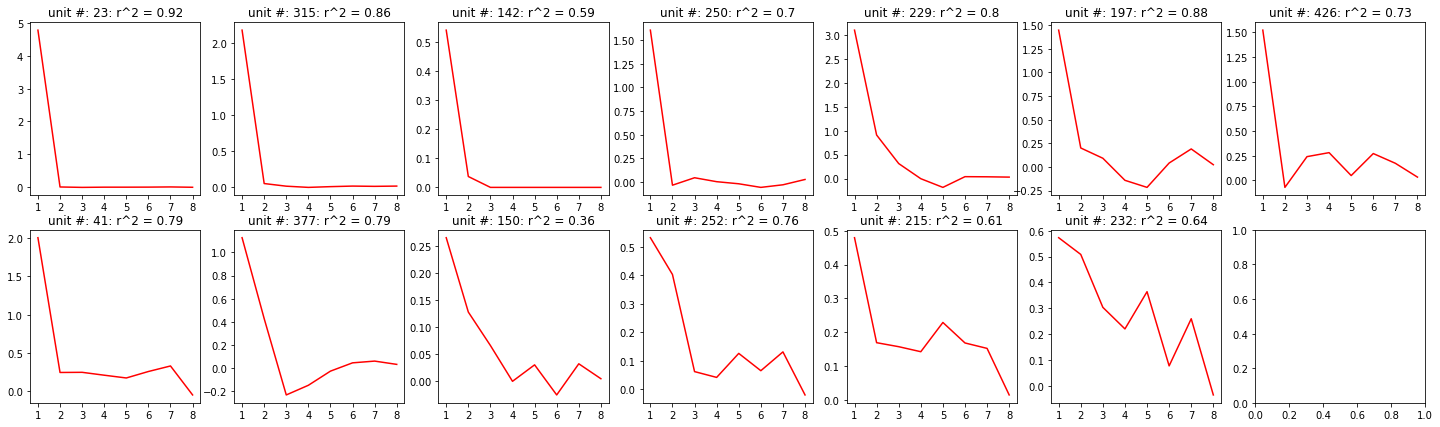

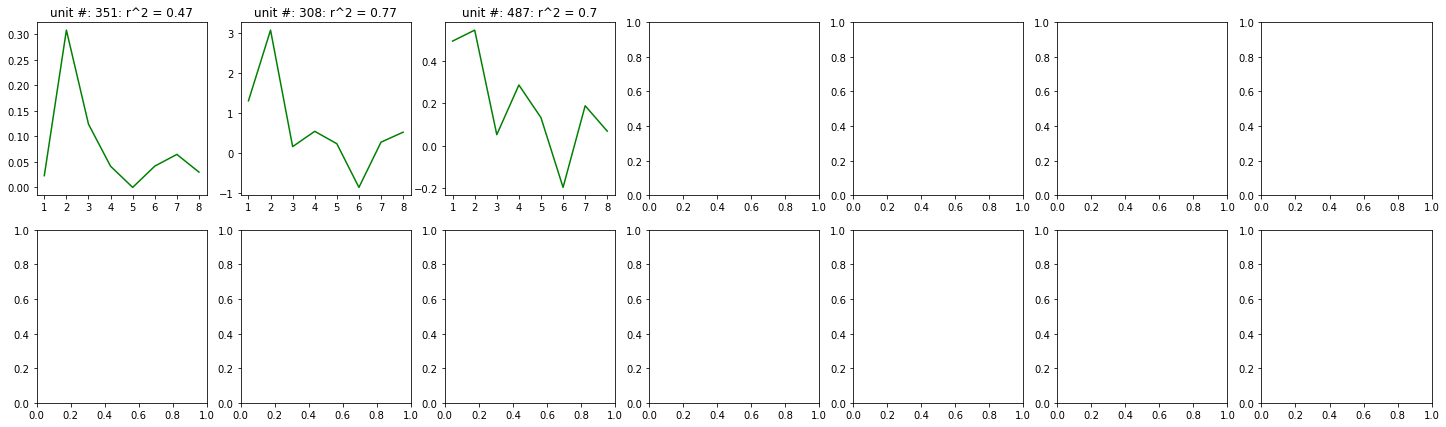

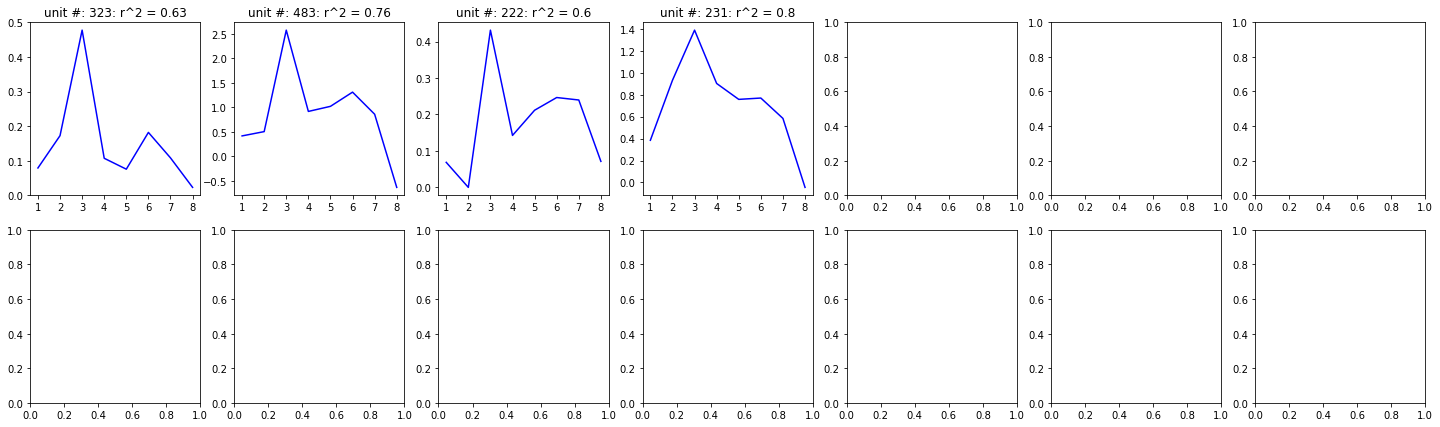

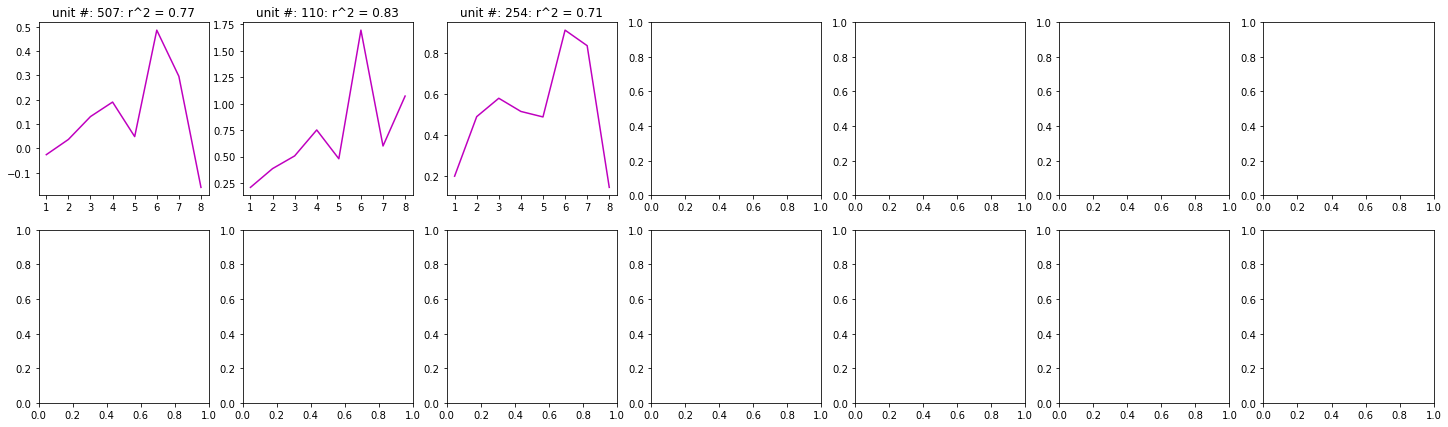

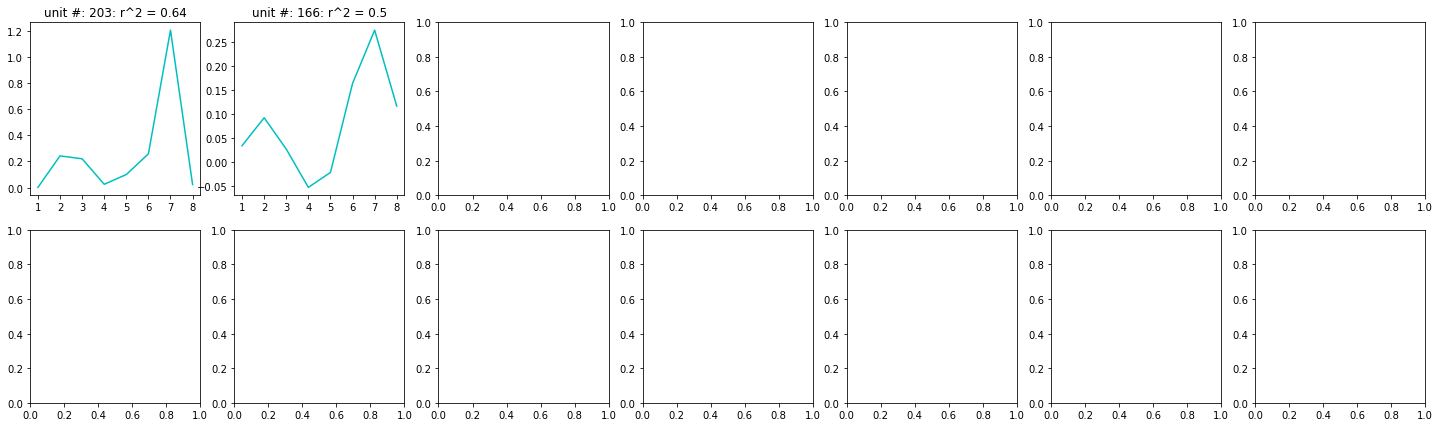

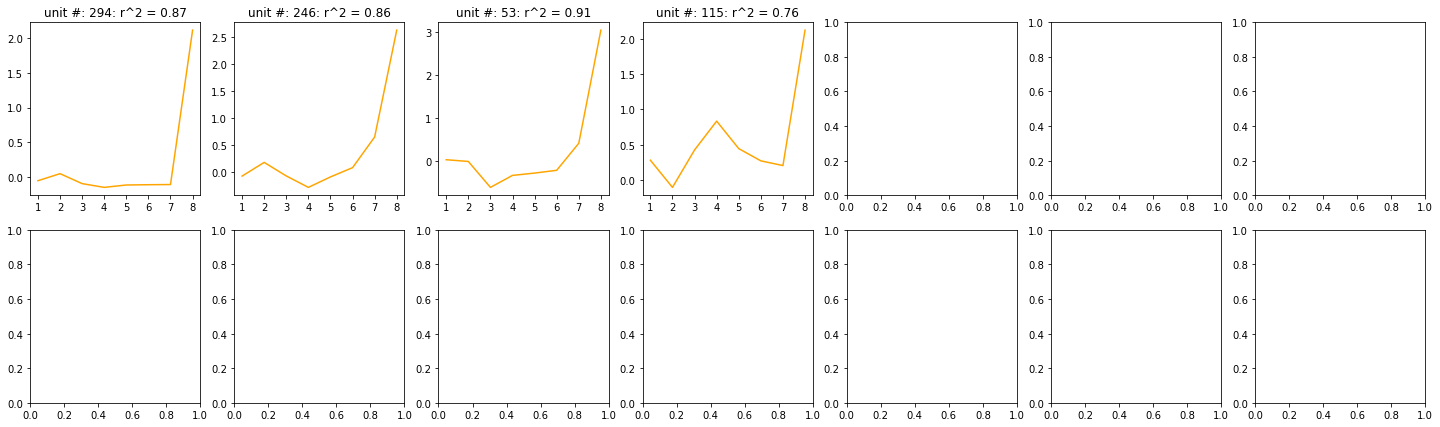

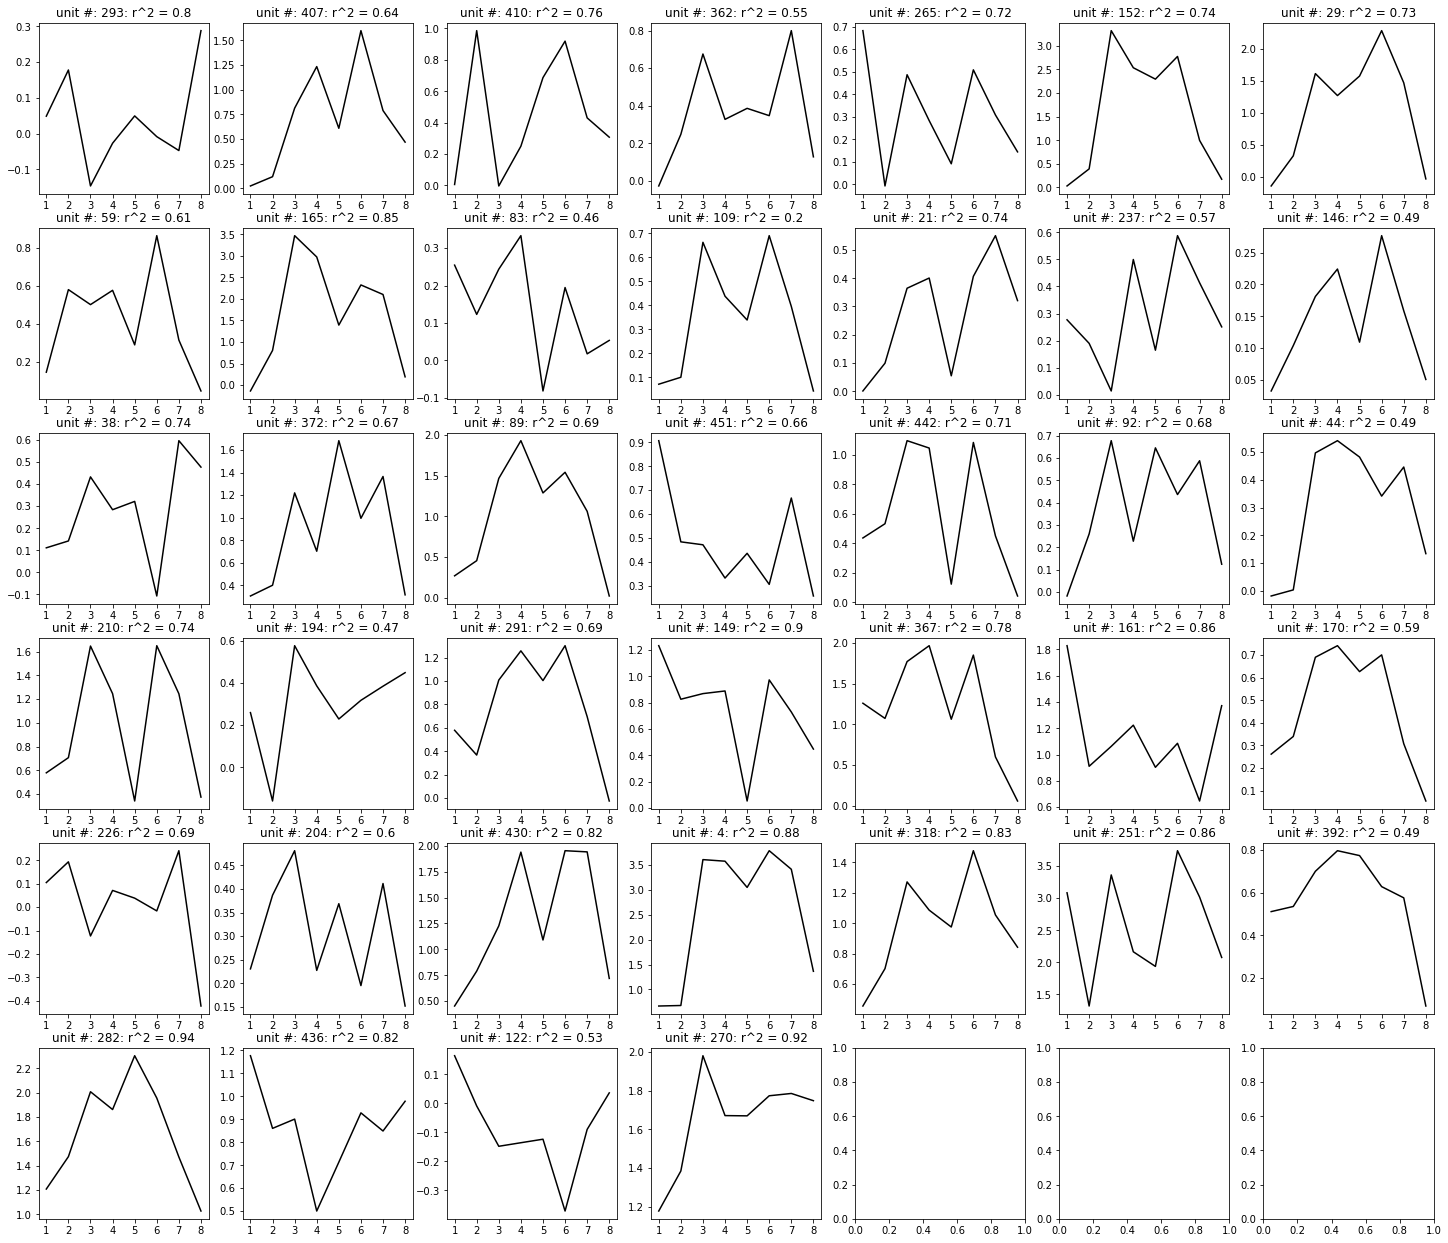

In [235]:
# Plotting the data
collist = ['r','g','b','y','y','m','c','orange','k']

for cat  in [0,1,2,5,6,7]:
    qx = sel_id[np.where(peakloc[sel_id] == cat)[0]]
    idx = qx[np.argsort(meancoef[qx])]
    fig, axs = plt.subplots(2,7, figsize=(25,7), facecolor='w', edgecolor='k')
    axs = axs.ravel();
    for npc,i in enumerate(idx):
        axs[npc].plot(np.mean(np.reshape(modelcoef[i,:],[26,8]),0), color = collist[cat])
        axs[npc].set_xticks(np.arange(0,8,1)); axs[npc].set_xticklabels(['1','2','3','4','5','6','7','8']);
        axs[npc].set_title('unit #: ' + str(wordSelUnit[i])+ ': r^2 = '+str(round(rfit[i],2)))

    plt.savefig("plots/pos_tuning_"+ str(cat) +".pdf")


# All other pairs
idx = oth_id[np.argsort(meancoef[oth_id])]
fig, axs = plt.subplots(6,7, figsize=(25,22), facecolor='w', edgecolor='k')
axs = axs.ravel();
for npc,i in enumerate(idx):
    axs[npc].plot(np.mean(np.reshape(modelcoef[i,:],[26,8]),0), color = 'k')
    axs[npc].set_xticks(np.arange(0,8,1)); axs[npc].set_xticklabels(['1','2','3','4','5','6','7','8']);
    axs[npc].set_title('unit #: ' + str(wordSelUnit[i])+ ': r^2 = '+str(round(rfit[i],2)))

    
plt.savefig("plots/pos_tuning_x.pdf")


In [ ]:
# Comparing both ends models
stimword = np.transpose(np.tile(wordlist,(8, 1))).flatten()
x = nBli['h'] #stimulus 

wordSelUnit = [4,21,23,29,38,41,44,53,59,83,89,92,109,110,115,122,142,146,149,150,152,161,165,166,170, 
              194,197,203,204,210,215,222,226,229,231,232,237,246,250,251,252,254,265,270,282,291,293,294,
              308,315,318,323,351,362,367,372,377,392,407,410,426,430,436,442,451,483,487,507]


# Setting up the parameters to perform PC
out = np.take(x,wordSelUnit[:],1)  # Analysing properties of individual word selective units
strlist = list(string.ascii_lowercase) # storing charaacters from A-Z

# Building the regression matrix for non-overlapping ends
Xmat = np.zeros((len(stimword), 26*8)) 
for i, seq in enumerate(stimword):
    mpt = round(len(seq)/2)
    for j, char in enumerate(seq[:mpt]):  # Left half of the words 
        if char in strlist:
            pid = (strlist.index(char)*8) + j
            Xmat[i,pid] += 1 
            
    for j, char in enumerate(seq[mpt:][::-1]):  # right half of the words 
        if char in strlist:
            pid = (strlist.index(char)*8) + 7 - j
            Xmat[i,pid] += 1 

rfit_nol = np.zeros((len(wordSelUnit)))
for npc in range(len(wordSelUnit)): 
    yobs = out[:,npc]       
    reg = LassoCV(cv=5, random_state=0).fit(Xmat, yobs)   
    corrval,pval = scipy.stats.pearsonr(Xmat@reg.coef_, out[:,npc])
    rfit_nol[npc] = corrval**2
    
print('Non-overlapping both-ends model done')  


###########  Filling the location from right to left
Xmat = np.zeros((len(stimword), 26*8)) 
for i, seq in enumerate(stimword):
    p1 = np.min([4,len(seq)])
    for j, char in enumerate(seq[:p1]):  # Left part 
        if char in strlist:
            pid = (strlist.index(char)*8) + j
            Xmat[i,pid] += 1 
            
    for j, char in enumerate(seq[-p1:][::-1]):  # Right part 
        if char in strlist:
            pid = (strlist.index(char)*8) + 7 - j
            Xmat[i,pid] += 1


rfit_ol = np.zeros((len(wordSelUnit)))
for npc in range(len(wordSelUnit)): 
    yobs = out[:,npc]       
    reg = LassoCV(cv=5, random_state=0).fit(Xmat, yobs)   
    corrval,pval = scipy.stats.pearsonr(Xmat@reg.coef_, out[:,npc])
    rfit_ol[npc] = corrval**2
    
plt.scatter(rfit_nol, rfit_ol); plt.plot([0,1],[0,1])
plt.xlabel('Non-overlapping end model')
plt.ylabel('Overlapping end model')

In [ ]:
# Fitting retinotopic models
stimword = np.transpose(np.tile(wordlist,(8, 1))).flatten()
x = nBli['h'] #stimulus 

wordSelUnit = [4,21,23,29,38,41,44,53,59,83,89,92,109,110,115,122,142,146,149,150,152,161,165,166,170, 
              194,197,203,204,210,215,222,226,229,231,232,237,246,250,251,252,254,265,270,282,291,293,294,
              308,315,318,323,351,362,367,372,377,392,407,410,426,430,436,442,451,483,487,507]


# Setting up the parameters to perform PC
out = np.take(x,wordSelUnit[:],1)  # Analysing properties of individual word selective units
strlist = list(string.ascii_lowercase) # storing charaacters from A-Z

# Building the regression matrix for non-overlapping ends
Xmat = np.zeros((len(stimword), 26*8)) 
for i, seq in enumerate(stimword):
    offset = int(4-len(seq)/2)
    for j, char in enumerate(seq[:mpt]):  # Left half of the words 
        if char in strlist:
            pid = (strlist.index(char)*8) + j + offset
            Xmat[i,pid] += 1 

rfit_ret = np.zeros((len(wordSelUnit)))
for npc in range(len(wordSelUnit)): 
    yobs = out[:,npc]       
    reg = LassoCV(cv=5, random_state=0).fit(Xmat, yobs)   
    corrval,pval = scipy.stats.pearsonr(Xmat@reg.coef_, out[:,npc])
    rfit_ret[npc] = corrval**2
    
plt.scatter(rfit_nol, rfit_ret); plt.plot([0,1],[0,1])
plt.xlabel('Non-overlapping end model')
plt.ylabel('Retinotopic model')

In [ ]:
# Comparing left-right vs right-left model fits
stimword = np.transpose(np.tile(wordlist,(8, 1))).flatten()
x = nBli['h'] #stimulus 

wordSelUnit = [4,21,23,29,38,41,44,53,59,83,89,92,109,110,115,122,142,146,149,150,152,161,165,166,170, 
              194,197,203,204,210,215,222,226,229,231,232,237,246,250,251,252,254,265,270,282,291,293,294,
              308,315,318,323,351,362,367,372,377,392,407,410,426,430,436,442,451,483,487,507]


# Setting up the parameters to perform PC
out = np.take(x,wordSelUnit[:],1)  # Analysing properties of individual word selective units
strlist = list(string.ascii_lowercase) # storing charaacters from A-Z

# Building the regression matrix
Xmat = np.zeros((len(stimword), 26*8)) 
for i, seq in enumerate(stimword):
    for j, char in enumerate(seq): 
        if char in strlist:
            pid = (strlist.index(char)*8) + j
            Xmat[i,pid] += 1 

rfit_lr = np.zeros((len(wordSelUnit)))
for npc in range(len(wordSelUnit)): 
    yobs = out[:,npc]       
    reg = LassoCV(cv=5, random_state=0).fit(Xmat, yobs)   
    corrval,pval = scipy.stats.pearsonr(Xmat@reg.coef_, out[:,npc])
    rfit_lr[npc] = corrval**2
    
print('LR model done')  
###########  Filling the location from right to left
Xmat = np.zeros((len(stimword), 26*8)) 
for i, seq in enumerate(stimword):
    pos_offset = 8 - len(seq)
    for j, char in enumerate(seq):
        if char in strlist:
            pid = (strlist.index(char)*8) + j + pos_offset
            Xmat[i,pid] += 1 


rfit_rl = np.zeros((len(wordSelUnit)))
for npc in range(len(wordSelUnit)): 
    yobs = out[:,npc]       
    reg = LassoCV(cv=5, random_state=0).fit(Xmat, yobs)   
    corrval,pval = scipy.stats.pearsonr(Xmat@reg.coef_, out[:,npc])
    rfit_rl[npc] = corrval**2
    
plt.scatter(rfit_lr, rfit_rl); plt.plot([0,1],[0,1])
plt.xlabel('Left to Right model')
plt.ylabel('Right to Left model')